In [1]:
import zipfile, py7zr
import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

import osmnx as ox
from shapely import LineString
import pickle
from collections import Counter
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
import alphashape

data_path = '../../data/'  
polygon_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
bike_detectors = gpd.read_file(data_path + 'all_bike_detectors.geojson')
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
policies_df_to_detectors = pd.read_csv(data_path + 'df_policies_with_detectors.csv')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')

output_path = "output/matched.csv"
output_detector_path = "output/detector.gpkg"

This notebook matches the links of the Paris counting network with the links of an OSM network:
- Load [OpenStreetMap network](https://www.openstreetmap.org/#map=7/51.330/10.453)
- Load [detector network](https://opendata.paris.fr/explore/dataset/referentiel-comptages-routiers/information/)
- Perform matching by angle and centroid


## Load networks


In [2]:
# get OSM dataframe
alpha_shape = alphashape.alphashape(polygon_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

# uncomment if you want it for different years
# overpass_settings = '[out:json][timeout:90][date:"' + \
#     str(2017) + '-01-01T00:00:00Z"]'
# ox.settings.overpass_settings = overpass_settings
ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_13110/134353857.py:14: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [3]:
df_osm.drop(columns=['width', 'bridge', 'tunnel', 'junction', 'access', 'ref'])

,osmid,oneway,name,highway,maxspeed,reversed,length,geometry,lanes,node_start,node_end,osm_id
0,4039102,True,Rue de Buzenval,residential,30,False,129.019,"LINESTRING (2.40137 48.85185, 2.40133 48.85192...",NaN,0,3194,1
1,54830382,False,Rue d'Avron,tertiary,30,False,62.470,"LINESTRING (2.40137 48.85185, 2.40128 48.85184...",2,0,5243,2
2,54830382,False,Rue d'Avron,tertiary,30,True,201.182,"LINESTRING (2.40137 48.85185, 2.40151 48.85188...",2,0,5418,3
3,32137109,True,Avenue de Gravelle,tertiary,30,False,12.581,"LINESTRING (2.40116 48.82954, 2.40127 48.82955...",2,1,8294,4
4,84416296,False,Rue de Tolbiac,secondary,30,False,154.093,"LINESTRING (2.36150 48.82635, 2.36186 48.82639...",3,2,6541,5
...,...,...,...,...,...,...,...,...,...,...,...,...
16534,"[890788332, 54180053]",True,Boulevard de la Madeleine,primary,30,False,71.340,"LINESTRING (2.32498 48.86936, 2.32519 48.86940...",2,8575,2460,16535
16535,"[362310464, 1258147339, 374059573]",True,Place de la Madeleine,primary,30,False,156.067,"LINESTRING (2.32498 48.86936, 2.32506 48.86941...",1,8575,755,16536
16536,1259802710,False,Rue du Théâtre,residential,30,False,9.760,None,4,8576,6777,16537
16537,28654007,False,Rue du Théâtre,residential,30,True,25.041,"LINESTRING (2.28374 48.85080, 2.28394 48.85069...",4,8576,4451,16538


In [4]:
# process car detectors

boundary_gdf = gpd.GeoDataFrame(
    geometry=[polygon], crs=df_car_detectors.crs)
df_car_detectors_without_dupl = df_car_detectors.drop_duplicates(
    subset='iu_ac', keep='first')
car_detectors_within_boundary = gpd.sjoin(
    df_car_detectors_without_dupl, boundary_gdf, op='within')
car_detectors_within_boundary = car_detectors_within_boundary.rename(
    columns={"iu_ac": "detector_id"})
df_detectors = car_detectors_within_boundary.copy()

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [5]:
# # Path to the CSV file giving the matching link IDs
# 

# # Path to a file containing the MATSim network with matching information for visualization
# output_matsim_path = "data/output/matsim.gpkg"

# # Path to a file containing the counting network with matching information for visualization


In [6]:
# Configure matching process

# Trade-off between scoring angle difference and centroid distance
alpha = 0.1

# Before finding the best match, we filter out unlikely matches

# Maximum centroid distance between two candidates
maximum_distance = 50

# Maximum angle difference between two candidates
maximum_angle = 15 * np.pi / 180.0

## Plot data

<Axes: >

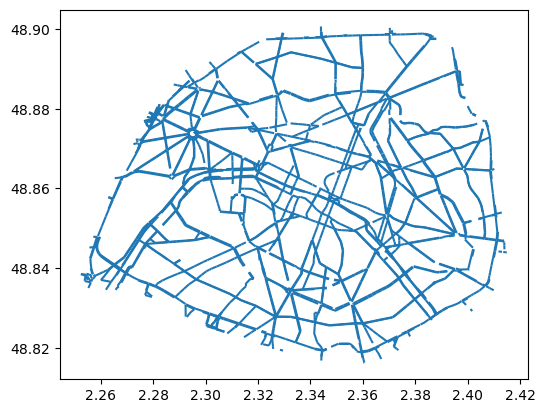

In [7]:
fig, ax = plt.subplots()
df_detectors.plot(ax=ax)

<Axes: >

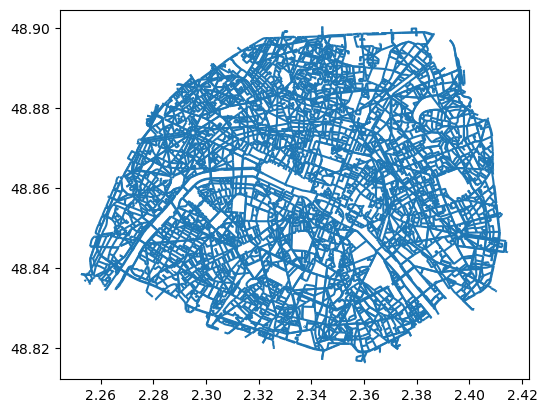

In [8]:
fig, ax = plt.subplots()
df_osm.plot(ax=ax)

In [9]:
# Filter osm network for higher order roads
df_osm_hor = df_osm[
    df_osm["highway"].str.contains("motorway") |
    df_osm["highway"].str.contains("trunk") |
    df_osm["highway"].str.contains("primary") |
    df_osm["highway"].str.contains("secondary") |
    df_osm["highway"].str.contains("tertiary")
]
df_osm_hor = df_osm_hor[df_osm_hor['geometry'].notnull()]

<Axes: >

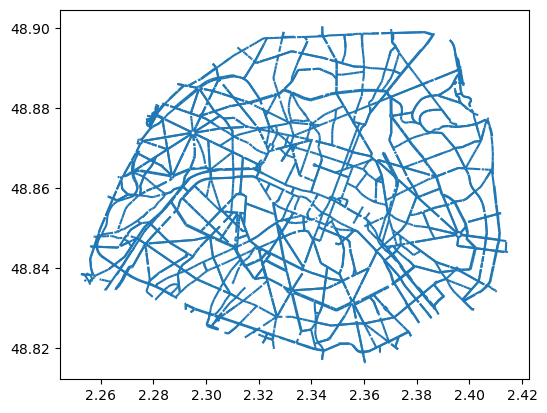

In [10]:
fig, ax = plt.subplots()
df_osm_hor.plot(ax=ax)

## Matching

In [11]:
# Calculate centroids
detector_centroids = np.vstack([
    df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T

osm_centroids = np.vstack([
    df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_13110/3904791298.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_13110/3904791298.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T


In [12]:
# Calculate orientation

def angle(geometry):
    coordinates = np.array(geometry.xy).T
    return np.arctan2(coordinates[-1, 1] - coordinates[0, 1], coordinates[-1, 0] - coordinates[0, 0])
    
detector_angles = df_detectors["geometry"].apply(angle).values
osm_angles = df_osm_hor["geometry"].apply(angle).values

In [13]:
# Calculate n-to-m distances
centroid_distances = np.zeros((len(detector_centroids), len(osm_centroids)))
angle_distances = np.zeros((len(detector_centroids), len(osm_centroids)))

In [14]:
for k in tqdm(range(len(detector_centroids))):
    centroid_distances[k,:] = la.norm(detector_centroids[k] - osm_centroids, axis = 1)
    angle_distances[k,:] = np.abs(detector_angles[k] - osm_angles)

angle_distances[angle_distances < 0.0] += 2.0 * np.pi

  0%|          | 0/2719 [00:00<?, ?it/s]

In [15]:
# Prepare scoring / matching
scores = centroid_distances + alpha * angle_distances

# Deactivate improbable matchings
scores[centroid_distances > maximum_distance] = np.inf
scores[angle_distances > maximum_angle] = np.inf

In [16]:
# Matching process
matchings = []
matched_scores = []

# The idea is relatively simple:
# - Find the matching with the smallest score among those with a finite value
# - Note down the matching, and set all matching containing the two links to Inf
# - Continue until no scores with finite value are left

current = np.count_nonzero(~np.isfinite(scores))

with tqdm(total = np.prod(scores.shape) - current) as progress:
    while np.count_nonzero(np.isfinite(scores)) > 0:
        # Find best score and note down
        index = np.unravel_index(np.argmin(scores), scores.shape)
        matched_scores.append(scores[index])

        # Set both invlved links to Inf
        scores[index[0], :] = np.inf
        scores[:, index[1]] = np.inf
        
        # Manage progress plotting
        update = np.count_nonzero(~np.isfinite(scores))
        
        if update > current:
            progress.update(update - current)
            current = update

        matchings.append(index)
        
matchings = np.array(matchings) # The matchings themselves (index reference, index matsim)
matched_scores = np.array(matched_scores) # The scores of the matchings

  0%|          | 0/1572824 [00:00<?, ?it/s]

In [17]:
df_detectors

,detector_id,date_debut,date_fin,libelle,iu_nd_aval,libelle_nd_aval,iu_nd_amont,libelle_nd_amont,geo_point_2d,geometry,index_right
1,1746,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Bd_Macdonald,3630,Bd Macdonald - Rue E. 019,929,Bd_Macdonald - Lounes Matoub,"{'lon': 2.3785952253516314, 'lat': 48.89874752...","LINESTRING (2.37634 48.89868, 2.38085 48.89881)",0
2,914,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Av_Pte_Vincennes,524,Pte_Vincennes-Acces_PI,514,Bd_Davout-Pte_de_Vincennes,"{'lon': 2.412529726334607, 'lat': 48.846824834...","LINESTRING (2.41126 48.84690, 2.41152 48.84693...",0
3,1708,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Bd_Ney,899,Ney-SNCF_Nord_1,112,Av_Pte_Poissonniers-Bd_Ney,"{'lon': 2.353299882519023, 'lat': 48.898320555...","LINESTRING (2.35254 48.89830, 2.35406 48.89834)",0
4,862,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Bd_Massena,497,Bd_Massena_Porte_de_France,495,Bd_Massena-Av-Pte_Vitry,"{'lon': 2.3783630199335652, 'lat': 48.82451111...","LINESTRING (2.37712 48.82405, 2.37960 48.82497)",0
6,737,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Bd_Jourdan,420,Bd_Jourdan-Tombe_Issoire,401,Jourdan-Deutsch_de_la_Meurthe,"{'lon': 2.332364057904252, 'lat': 48.821818375...","LINESTRING (2.33430 48.82139, 2.33043 48.82225)",0
...,...,...,...,...,...,...,...,...,...,...,...
3717,29,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Rivoli,28,Rivoli-Bourdonnais,29,Rivoli-Dechargeurs,"{'lon': 2.345237130236162, 'lat': 48.859500829...","LINESTRING (2.34565 48.85937, 2.34482 48.85963)",0
3718,6125,1998-04-16 02:00:00+00:00,2023-01-01 01:00:00+00:00,Bd_Diderot,2582,Av_Daumesnil-Bd_Diderot,3176,Bd_Diderot-Legraverend,"{'lon': 2.3765843934877866, 'lat': 48.84613349...","LINESTRING (2.37579 48.84604, 2.37738 48.84623)",0
3719,348,1996-10-03 02:00:00+00:00,2023-01-01 01:00:00+00:00,Sevres,202,Sevres-Babylone,118,Sevres-Sts_Peres,"{'lon': 2.327716286504817, 'lat': 48.851806970...","LINESTRING (2.32855 48.85194, 2.32734 48.85173...",0
3720,4612,1996-10-16 02:00:00+00:00,2023-01-01 01:00:00+00:00,Av_Pdt_Wilson,2345,Av_Marceau-Av_Pdt_Wilson,3445,Place_de_Tokyo,"{'lon': 2.2984040564728376, 'lat': 48.86488154...","LINESTRING (2.29684 48.86481, 2.29997 48.86496)",0


## Output

In [18]:
# Construct a data set containing all matching information
df_matching = pd.DataFrame({
    "detector_id": df_detectors.iloc[matchings[:, 0]]["detector_id"].values,
    "osm_id": df_osm_hor.iloc[matchings[:,1]]["osm_id"].values,
    "lanes": df_osm_hor.iloc[matchings[:, 1]]["lanes"].values,
    "highway": df_osm_hor.iloc[matchings[:, 1]]["highway"].values,
    "oneway": df_osm_hor.iloc[matchings[:, 1]]["oneway"].values,
    "length": df_osm_hor.iloc[matchings[:, 1]]["length"].values,
    "score": matched_scores
})

In [19]:
df_matching = df_matching.sort_values(by='detector_id')

df_matching.to_csv(output_path, sep=";", index=False)

In [20]:
df_matching

,detector_id,osm_id,lanes,highway,oneway,length,score
2363,1,3460,5,primary,True,49.085,0.007585
1228,10,956,4,primary,True,148.501,0.001413
1682,100,3189,2,secondary,True,120.932,0.002284
2698,1005,6130,2,secondary,False,73.209,0.017635
1569,1006,13628,1,secondary,True,10.593,0.002014
...,...,...,...,...,...,...,...
2429,986,12323,2,tertiary,True,33.766,0.008839
1208,99,3214,2,secondary,False,47.418,0.001388
801,994,11903,4,primary,False,117.098,0.000969
2068,996,16310,4,primary,False,148.970,0.004179


In [24]:
df_comparison = df_detectors.copy()
df_comparison = pd.merge(df_comparison, df_matching)
# df_comparison.to_file("output/detectors_matched_2_osm.geojson", driver = 'GeoJSON')

In [ ]:
osm_matched_2_detectors = df_osm_hor.copy()
osm_matched_2_detectors = pd.merge(osm_matched_2_detectors, df_matching)
# osm_matched_2_detectors.to_file(
#     "output/osm_matched_2_detectors.geojson", driver='GeoJSON')